In [1]:
import torch
import torch.nn.functional as F
from PIL import Image, ImageFilter
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients, visualization
from transformers import AutoProcessor, Gemma3ForConditionalGeneration
import re
import cv2  # oder PIL

In [2]:
# Model- und Processor-Setup
model_id = "merged_model_batchsize_2_with_vision_tower"
torch.manual_seed(8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEBUG: device", device)

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
tokenizer = processor.tokenizer
model = Gemma3ForConditionalGeneration.from_pretrained(
    model_id, trust_remote_code=True
).to(device)
model.eval().zero_grad()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


DEBUG: device cuda


Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

In [3]:
def load_image_from_url(image_path):
    return Image.open(image_path).convert("RGB")

In [4]:
# Eigenes Colormap fuer Heatmaps
default_cmap = LinearSegmentedColormap.from_list(
    "custom_blue",
    [(0, "#ffffff"), (0.25, "#252b36"), (1, "#000000")],
    N=256
)

In [12]:
def vqa_vilt_interpret_seq_attr(
    image_filename,
    question,
    true_answer,
    model,
    processor,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    max_gen_len=20
):
    # 1) Bild laden + verschwommene Baseline
    img = load_image_from_url(image_filename)
    blurred = img.filter(ImageFilter.GaussianBlur(radius=5))
    blur_inputs = processor.apply_chat_template(
        [{"role":"user","content":[{"type":"image","image":blurred}]}],
        tokenize=True, return_dict=True, return_tensors="pt",
        padding=True, truncation=True,
        do_pan_and_scan=False, add_generation_prompt=True
    ).to(device)
    blur_px      = blur_inputs["pixel_values"]
    img_token_id = processor.tokenizer.image_token_id

    # 2) Prompt (Bild + Text) tokenisieren
    inputs      = processor.apply_chat_template(
        [{"role":"user","content":[
            {"type":"image","image":img},
            {"type":"text","text":question}
        ]}],
        tokenize=True, return_dict=True, return_tensors="pt",
        padding=True, truncation=True,
        do_pan_and_scan=False, add_generation_prompt=True
    ).to(device)
    px          = inputs["pixel_values"]
    input_ids   = inputs["input_ids"]
    attention   = inputs["attention_mask"]
    text_embeds = model.get_input_embeddings()(input_ids)
    prompt_len  = input_ids.shape[1]


    # 3) Antwort generieren und decodieren
    gen_out   = model.generate(
        pixel_values=px,
        input_ids=input_ids,
        attention_mask=attention,
        max_length=prompt_len + max_gen_len,
        return_dict_in_generate=True
    )
    full_ids  = gen_out.sequences.to(device)  # [1, total_len]
    gen_ids   = full_ids[0, prompt_len:].tolist()
    pred_ans  = processor.tokenizer.decode(gen_ids, skip_special_tokens=True).strip()

    # 4) Embeddings fuer Captum
    total_len    = full_ids.shape[1]
    full_embeds  = model.get_input_embeddings()(full_ids)
    pad_id       = processor.tokenizer.pad_token_id
    base_ids     = torch.full_like(full_ids, pad_id)
    base_embeds  = model.get_input_embeddings()(base_ids)
    attn_full    = torch.ones_like(full_ids)

    # 5) forward_joint wie gehabt (Bilder in die Embeddings einscatter)
    def forward_joint(px_batch, txt_emb, attn_batch):
        n_steps, seq_len, hid = txt_emb.shape
        img_feats = model.get_image_features(px_batch)
        flat_txt  = txt_emb.view(-1, hid)
        flat_img  = img_feats.view(-1, hid)
        mask0     = (full_ids.view(-1) == img_token_id)
        mask_all  = mask0.repeat(n_steps)
        flat_txt[mask_all] = flat_img
        merged    = flat_txt.view(n_steps, seq_len, hid)
        expanded_attn = attn_batch.repeat(n_steps, 1)
        logits    = model(
            input_ids=None,
            pixel_values=None,
            inputs_embeds=merged,
            attention_mask=expanded_attn,
            use_cache=False,
        ).logits
        log_probs = F.log_softmax(logits, dim=-1)
        # Summe der Log-Prob fuer jeden Step
        out = []
        for i in range(n_steps):
            lp = torch.zeros((), device=log_probs.device)
            for pos in range(prompt_len, seq_len):
                tok = full_ids[0, pos]
                lp = lp + log_probs[i, pos, tok]
            out.append(lp)
        return torch.stack(out)

    # 6) Integrated Gradients
    px.requires_grad_(True)
    full_embeds.requires_grad_(True)
    ig = IntegratedGradients(forward_joint)
    attr_img, attr_txt = ig.attribute(
        inputs=(px, full_embeds),
        baselines=(blur_px, base_embeds),
        additional_forward_args=(attn_full,),
        method = "riemann_trapezoid",
        n_steps=300,
        internal_batch_size=1
    )

    # 7) Bild-Attribution
    orig_np = np.array(img)
    img_attr = attr_img.squeeze(0).cpu().detach().numpy().transpose(1,2,0)
    #visualization.visualize_image_attr_multiple(
    #    img_attr, orig_np,
    #    ["original_image","heat_map"], ["all","absolute_value"],
    #    titles=["Original","Attribution"],
    #    cmap=default_cmap,
    #    show_colorbar=True
    #)
    attr_np = attr_img[0].squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    h_orig, w_orig = img.size[1], img.size[0]      # PIL: .size = (W,H)
    attr_up = cv2.resize(attr_np, (w_orig, h_orig), interpolation=cv2.INTER_LINEAR)
    # 8) Text-Attribution mit Token-Filter und normierung
    raw_text_attr = attr_txt.sum(dim=2).squeeze(0).cpu().detach().numpy()
    tokenized     = processor.tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
    special       = set(processor.tokenizer.all_special_tokens)
    extra         = {"user","model","#start_of_turn","#end_of_turn"}
    special_tokens = set(processor.tokenizer.all_special_tokens)
    filtered = []
    for tok, attr in zip(tokenized, raw_text_attr):
        # 1) SatzPiece-Prefix entfernen
        clean = tok.lstrip("▁")

        # 2) Alles in spitzen Klammern überspringen: <start_of_turn>, <end_of_turn>, <image_soft_token> etc.
        if re.match(r"^<.*>$", tok):
            continue

        # 3) Sonder-Tokens des Tokenizers überspringen
        if tok in special_tokens:
            continue

        # 4) ggf. Rollen-Wörter ("user", "model", ...) überspringen
        if clean.lower() in {"user", "model"}:
            continue

        filtered.append((clean, attr))

    if filtered:
        tokens_real, text_attr_real = zip(*filtered)
        text_attr_real = np.array(text_attr_real)
        text_attr_real /= np.linalg.norm(text_attr_real) + 1e-8
    else:
        tokens_real, text_attr_real = [], np.array([])

    tokens_real, text_attr_real = zip(*filtered)
    text_attr_real = np.array(text_attr_real)
    text_attr_real /= (np.linalg.norm(text_attr_real) + 1e-8)

    vis_data = [ visualization.VisualizationDataRecord(
        text_attr_real,                  # attribution scores pro Token
        1.0,                             # pred_prob (dummy)
        pred_ans,                        # pred_class
        true_answer,                     # true_class
        true_answer,                     # attr_class
        text_attr_real.sum(),            # attr_score
        tokens_real,                     # raw_input_ids
        0.0                              # convergence_score
    )]
    visualization.visualize_text(vis_data)
        # Bild-Attribution
    orig_img = np.asarray(img)
    #img_attr = np.transpose(attributions[0].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    orig_img = np.asarray(img)   # PIL → ndarray
    visualization.visualize_image_attr_multiple(
        attr_up, 
        orig_img,
        ["original_image", "heat_map"], ["all", "absolute_value"],
        titles=["Original Image", "Attribution Magnitude"],
        cmap=default_cmap,
        show_colorbar=True,
    )
    # 9) Konsolenausgabe
    print("Image-Beitrag:", attr_img.sum().item())
    print("Text-Beitrag: ", text_attr_real.sum())
    print("Total-Beitrag:", attr_img.sum().item() + text_attr_real.sum())
    print("-"*60)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
female reproductive system,female reproductive system (1.00),female reproductive system,-2.59,where does this part belong to ?


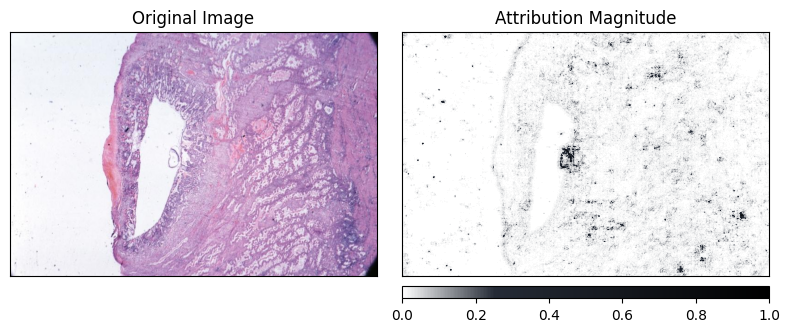

Image-Beitrag: -24.54775047302246
Text-Beitrag:  -2.5880382
Total-Beitrag: -27.135788679122925
------------------------------------------------------------


In [15]:
if __name__ == "__main__":
    image_path   = "uterus.png"
    questions    = ["where does this part belong to?"]
    true_answers = ["female reproductive system"]

    for q, a in zip(questions, true_answers):
        vqa_vilt_interpret_seq_attr(
            image_filename=image_path,  # hier dein Bildpfad
            question=q,
            true_answer=a,
            model=model,
            processor=processor,
            device=device,
            max_gen_len=20
        )